# Top-label calibration for outputs of ML models

The goal of this notebook is to present :class:`mapie.calibration.MapieCalibrator` by comparing it to the method presented in the paper for Top-label calibration [1].

[1] Gupta, Chirag, and Aaditya K. Ramdas. "Top-label calibration and multiclass-to-binary reductions." arXiv preprint arXiv:2107.08353 (2021).

In [1]:
!git clone https://github.com/AIgen/df-posthoc-calibration
!cd df-posthoc-calibration && git checkout 109da93c1487cb38ee51fcac47088cdd29854999


Cloning into 'df-posthoc-calibration'...
remote: Enumerating objects: 309, done.
remote: Counting objects: 100% (197/197), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 309 (delta 101), reused 183 (delta 89), pack-reused 112
Receiving objects: 100% (309/309), 60.76 MiB | 8.86 MiB/s, done.
Resolving deltas: 100% (132/132), done.
Note: switching to '109da93c1487cb38ee51fcac47088cdd29854999'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at 109da93 Create README.md


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/scikit-learn-contrib/MAPIE/blob/master/notebooks/classification/top_label_calibration.ipynb)


# Tutorial preparation

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier

from mapie.calibration import MapieCalibrator
from mapie.metrics import top_label_ece

import sys

sys.path.append("df-posthoc-calibration/")
import assessment
import calibration 

random_state = 20

%matplotlib inline


# 1. Creating a classification dataset

In [3]:
centers = [(0, 3.5), (-2, 0), (2, 0)]
covs = [np.eye(2), np.eye(2)*2, np.diag([5, 1])]
x_min, x_max, y_min, y_max, step = -6, 8, -6, 8, 0.1
n_samples = 1000
n_classes = 3
np.random.seed(42)
X = np.vstack([
    np.random.multivariate_normal(center, cov, n_samples)
    for center, cov in zip(centers, covs)
])
y = np.hstack([np.full(n_samples, i) for i in range(1, n_classes+1)])

X_train_cal, X_test, y_train_cal, y_test = train_test_split(
    X, y, test_size=0.2, random_state=random_state
)
X_train, X_cal, y_train, y_cal = train_test_split(
    X_train_cal, y_train_cal, test_size=0.25, random_state=random_state
)


# 2. Fitting a classifier on the training data

In [4]:
clf = RandomForestClassifier(random_state=random_state)
clf.fit(X_train, y_train)


RandomForestClassifier(random_state=20)

### Computing the prediction probabilities using the trained classifier

In [5]:
preds_calib = clf.predict_proba(X_cal)
preds_test = clf.predict_proba(X_test)
arg_max_preds_test = clf.classes_[np.argmax(preds_test, axis=1)]

### Evaluating model

              precision    recall  f1-score   support

           1       0.94      0.93      0.93       208
           2       0.82      0.85      0.83       198
           3       0.88      0.85      0.86       194

    accuracy                           0.88       600
   macro avg       0.88      0.88      0.88       600
weighted avg       0.88      0.88      0.88       600



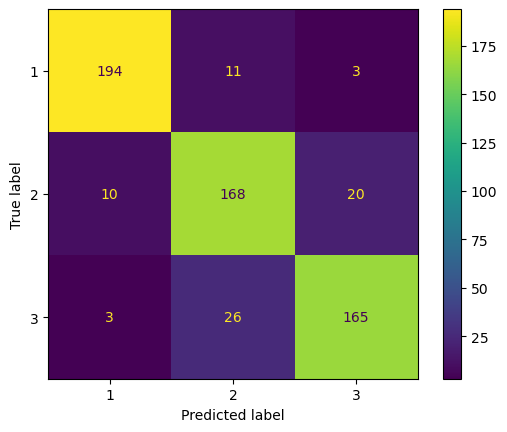

In [6]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()
plt.show()

# 3. Calibration of data

### Using method Top-Label calibration (see section 2 of paper [1]).

In [7]:
points_per_bin=50

# initialize recalibrator and set number of points per bins
hb = calibration.HB_toplabel(points_per_bin=points_per_bin)
hb.fit(preds_calib, y_cal)

# get histogram binning probabilities on test data
preds_test_hb = hb.predict_proba(preds_test)

### Using MAPIE `calibration.py`

In [8]:
mapie_reg = MapieCalibrator(estimator=clf, cv="prefit", calibrator="isotonic")
mapie_reg.fit(X_cal, y_cal)
mapie_prob_preds = mapie_reg.predict_proba(X_test)
mapie_preds = mapie_reg.predict(X_test)


In [9]:
# Verification that the same predictions are made.
np.testing.assert_array_equal(mapie_preds, clf.classes_[np.nanargmax(mapie_prob_preds, axis=1)])


# 4. Evaluating the models using ECE and Reliability diagrams introduced in [1].

Note that since we use different calibration methods, the results are slightly different, however, we still find similar results.

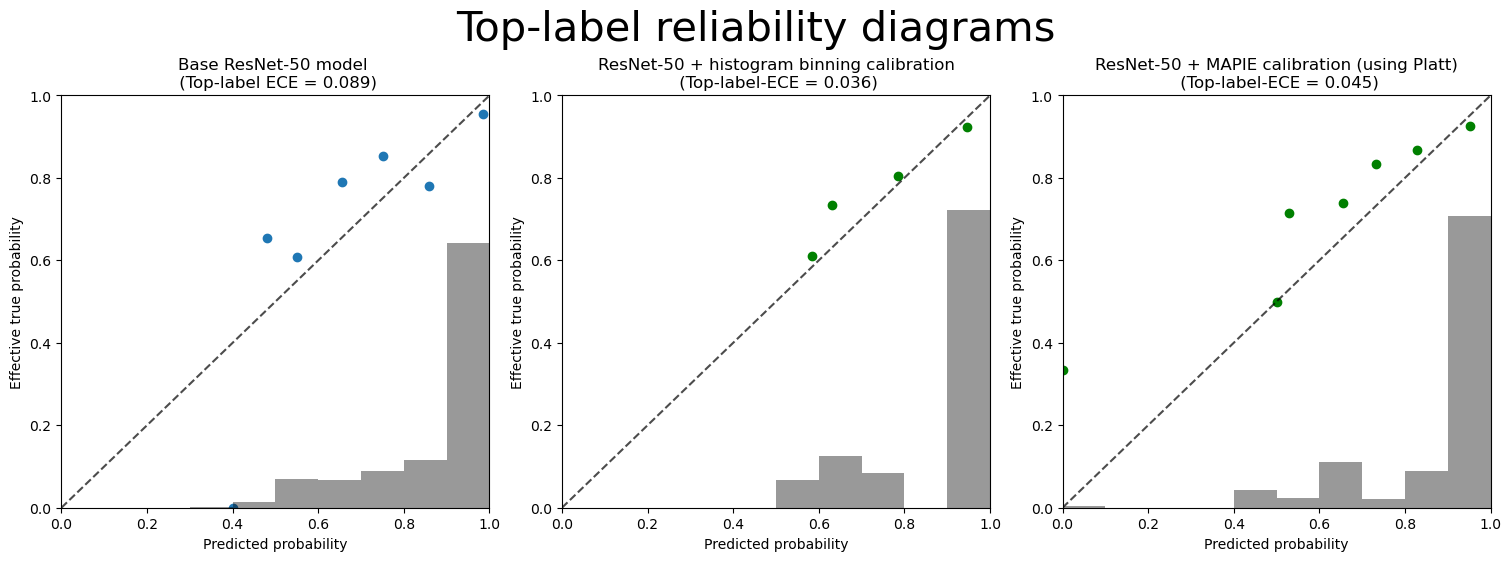

In [10]:
# make some plots
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5.5), constrained_layout=True)
fig.suptitle('Top-label reliability diagrams', fontsize=30)

assessment.toplabel_reliability_diagram(y_test, preds_test, ax=ax[0])
ax[0].set_title("Base ResNet-50 model \n (Top-label ECE = {:.3f})".format(top_label_ece(y_test, np.nanmax(preds_test, axis=1), arg_max_preds_test)))

assessment.toplabel_reliability_diagram(y_test, preds_test_hb, arg_max_preds_test, ax=ax[1], color='g')
ax[1].set_title("ResNet-50 + histogram binning calibration\n (Top-label-ECE = {:.3f})".format(top_label_ece(y_test, preds_test_hb, arg_max_preds_test)));

assessment.toplabel_reliability_diagram(y_test, np.nanmax(mapie_prob_preds, axis=1), arg_max_preds_test, ax=ax[2], color='g')
ax[2].set_title("ResNet-50 + MAPIE calibration (using Platt)\n (Top-label-ECE = {:.3f})".format(top_label_ece(y_test, np.nanmax(mapie_prob_preds, axis=1), arg_max_preds_test)));

In [11]:
!rm -r -f df-posthoc-calibration